# Objective : Web Services  Classification 
## Our goal is to build a baseline model with at least 80% accuracy

## 1. Load Python Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import os
import pickle
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

# Notebook settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

# Setup directories
os.makedirs("charts", exist_ok=True)
os.makedirs("results", exist_ok=True)
label_encoder = LabelEncoder()

## 2. Basic Inspection on given dataset

In [2]:

def basic_inspection_dataset(table):
    print("Top 5 Records of dataset")
    print(table.head())
    print()
        
    print("Bottom 5 Records of dataset")
    print(table.tail())
    print()
    
    print("Column/features/Variable  - Names of Given dataset")
    print(table.columns)
    print()
    
    print("Shape(rows x columns) - of Given dataset")
    print(table.shape)
    print()
    
    print("Data types - Given Column Names")
    print(table.dtypes)
    print()
    
    print("Summry of dataset")
    print(table.info())
    print()
    
    print("To see the count of null/nan values in columns of dataset")
    print(table.isnull().value_counts())
    print()
    
    print("Dataset Summary ")
    print(table.describe())
    print()
    


## 3. Preprocessing Web Service Descriptions

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return " ".join(lemmatized_tokens)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 4. Feature Extraction from Web Service Descriptions using TF-IDF and Sentence Transformers (all-MiniLM-L6-v2)

In [4]:
def vectorize_descriptions(service_list, max_features=1000):
    """
    Converts a list of service descriptions into a DataFrame of TF-IDF features.
    Limits to top `max_features` terms by importance across the corpus.
    """
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(service_list)
    feature_names = vectorizer.get_feature_names_out()
    
    return pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


def embed_descriptions_with_sbert(services, model_name='all-MiniLM-L6-v2'):
    """
    Converts service descriptions into SBERT embeddings using SentenceTransformer.
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(services, show_progress_bar=True)
    
    return pd.DataFrame(embeddings, index=services.index if isinstance(services, pd.Series) else None)

## 5. Generate Report in CSV

In [5]:
def generate_report_csv(report_dict, confusion_mat, class_labels, output_file="ML-Report.csv"):
    df = pd.DataFrame(report_dict).transpose()

    # Filter only class label rows
    df = df.loc[[str(cls) for cls in class_labels if str(cls) in df.index]].copy()

    # Compute per-class accuracy
    row_sums = confusion_mat.sum(axis=1)
    diagonal = np.diag(confusion_mat)
    per_class_accuracy = (diagonal / row_sums).round(2)

    df['accuracy'] = per_class_accuracy
    if 'support' in df.columns:
        df = df.drop(columns=['support'])

    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Category'}, inplace=True)

    df.to_csv(f"results/{output_file}", index=False)
    print(f"Classification report saved to: {output_file}")

## 6. Confusion Matrix - Show - Save

In [6]:
def generate_confusion_heatmap(cm, class_names, name):
    n_classes = len(class_names)
    figsize = (18, 18) if n_classes >= 40 else (8, 8)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 6})
    plt.title(f'Confusion Matrix: {name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    save_path = f"charts/ML_confusion_matrix_{name.replace(' ', '_')}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to: {save_path}")

## 7. Evaluate Model

In [7]:
def evaluate_and_report(y_test, y_pred, name, labels, class_names):
    print(f"\n {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    report = classification_report(y_test, y_pred, output_dict=True, labels=labels)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    generate_report_csv(report, cm, class_labels=labels, output_file=f"ML-Report-{name}.csv")
    generate_confusion_heatmap(cm, class_names, name)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

## 8. Train  - Model

In [8]:
def train_and_report_logistic(X_train, X_test, y_train, y_test, name="LogReg"):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    labels = np.unique(y_test)
    result = evaluate_and_report(y_test, y_pred, name, labels, labels)
    result["model"] = "LogReg"
    return result


def train_and_report_random_forest(X_train, X_test, y_train, y_test, name="RandomForest"):
    labels = np.unique(y_train)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train)
    class_weights_dict = dict(zip(labels, weights))

    model = RandomForestClassifier(n_estimators=200, class_weight=class_weights_dict, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    result = evaluate_and_report(y_test, y_pred, name, labels, labels)
    result["model"] = "RF"
    return result


def train_and_report_xgboost(X_train, X_test, y_train_text, y_test_text, name="XGBoost"):
    y_train = label_encoder.fit_transform(y_train_text)
    y_test = label_encoder.transform(y_test_text)

    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    sample_weights = np.array([dict(zip(classes, weights))[label] for label in y_train])

    model = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)

    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    class_names = label_encoder.inverse_transform(np.unique(y_test))

    result = evaluate_and_report(y_test_labels, y_pred_labels, name, class_names, class_names)
    result["model"] = "XGB"
    return result

## 9. Models

                                    Service Description  \
0     CloudMine is a backend-as-a-service platform t...   
1     TwitrPix gives users the ability to share phot...   
2     The Statistical Institute of Catalonia (Idesca...   
3     With this API, devlopers can write their own p...   
4     Subsonic is a free music streamer that allows ...   
...                                                 ...   
8995  The Haralyzer API allows developers to store r...   
8996  The Stickybits API enables developers to write...   
8997  The FIX API has existing software that uses FI...   
8998  FeeFighters is a comparison shopping website f...   
8999  The Proximus EnCo Smartliving.io API integrate...   

     Service Classification    Grouped Category  
0                   Backend             Backend  
1                    Photos              Photos  
2                Government          Government  
3                    Photos              Photos  
4                     Music              

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

SBERT embeddings saved to: ../processed-extacted-features/Processed_Top_45_Web_Services_SBERT_Embeddings.csv

 LogReg TFIDF + SBERT with 45 Web Services Classification Report:

                         precision    recall  f1-score   support

            Advertising       0.78      0.57      0.66        37
              Analytics       0.75      0.73      0.74        49
Application Development       0.76      0.53      0.62        53
                Backend       0.64      0.64      0.64        36
                Banking       0.98      0.93      0.96        46
                Bitcoin       0.94      0.89      0.92        37
                   Chat       0.92      0.88      0.90        40
                  Cloud       0.74      0.81      0.77        36
                   Data       0.69      0.63      0.66        38
               Database       0.62      0.65      0.64        43
                Domains       0.95      1.00      0.98        41
              Education       0.85      0.

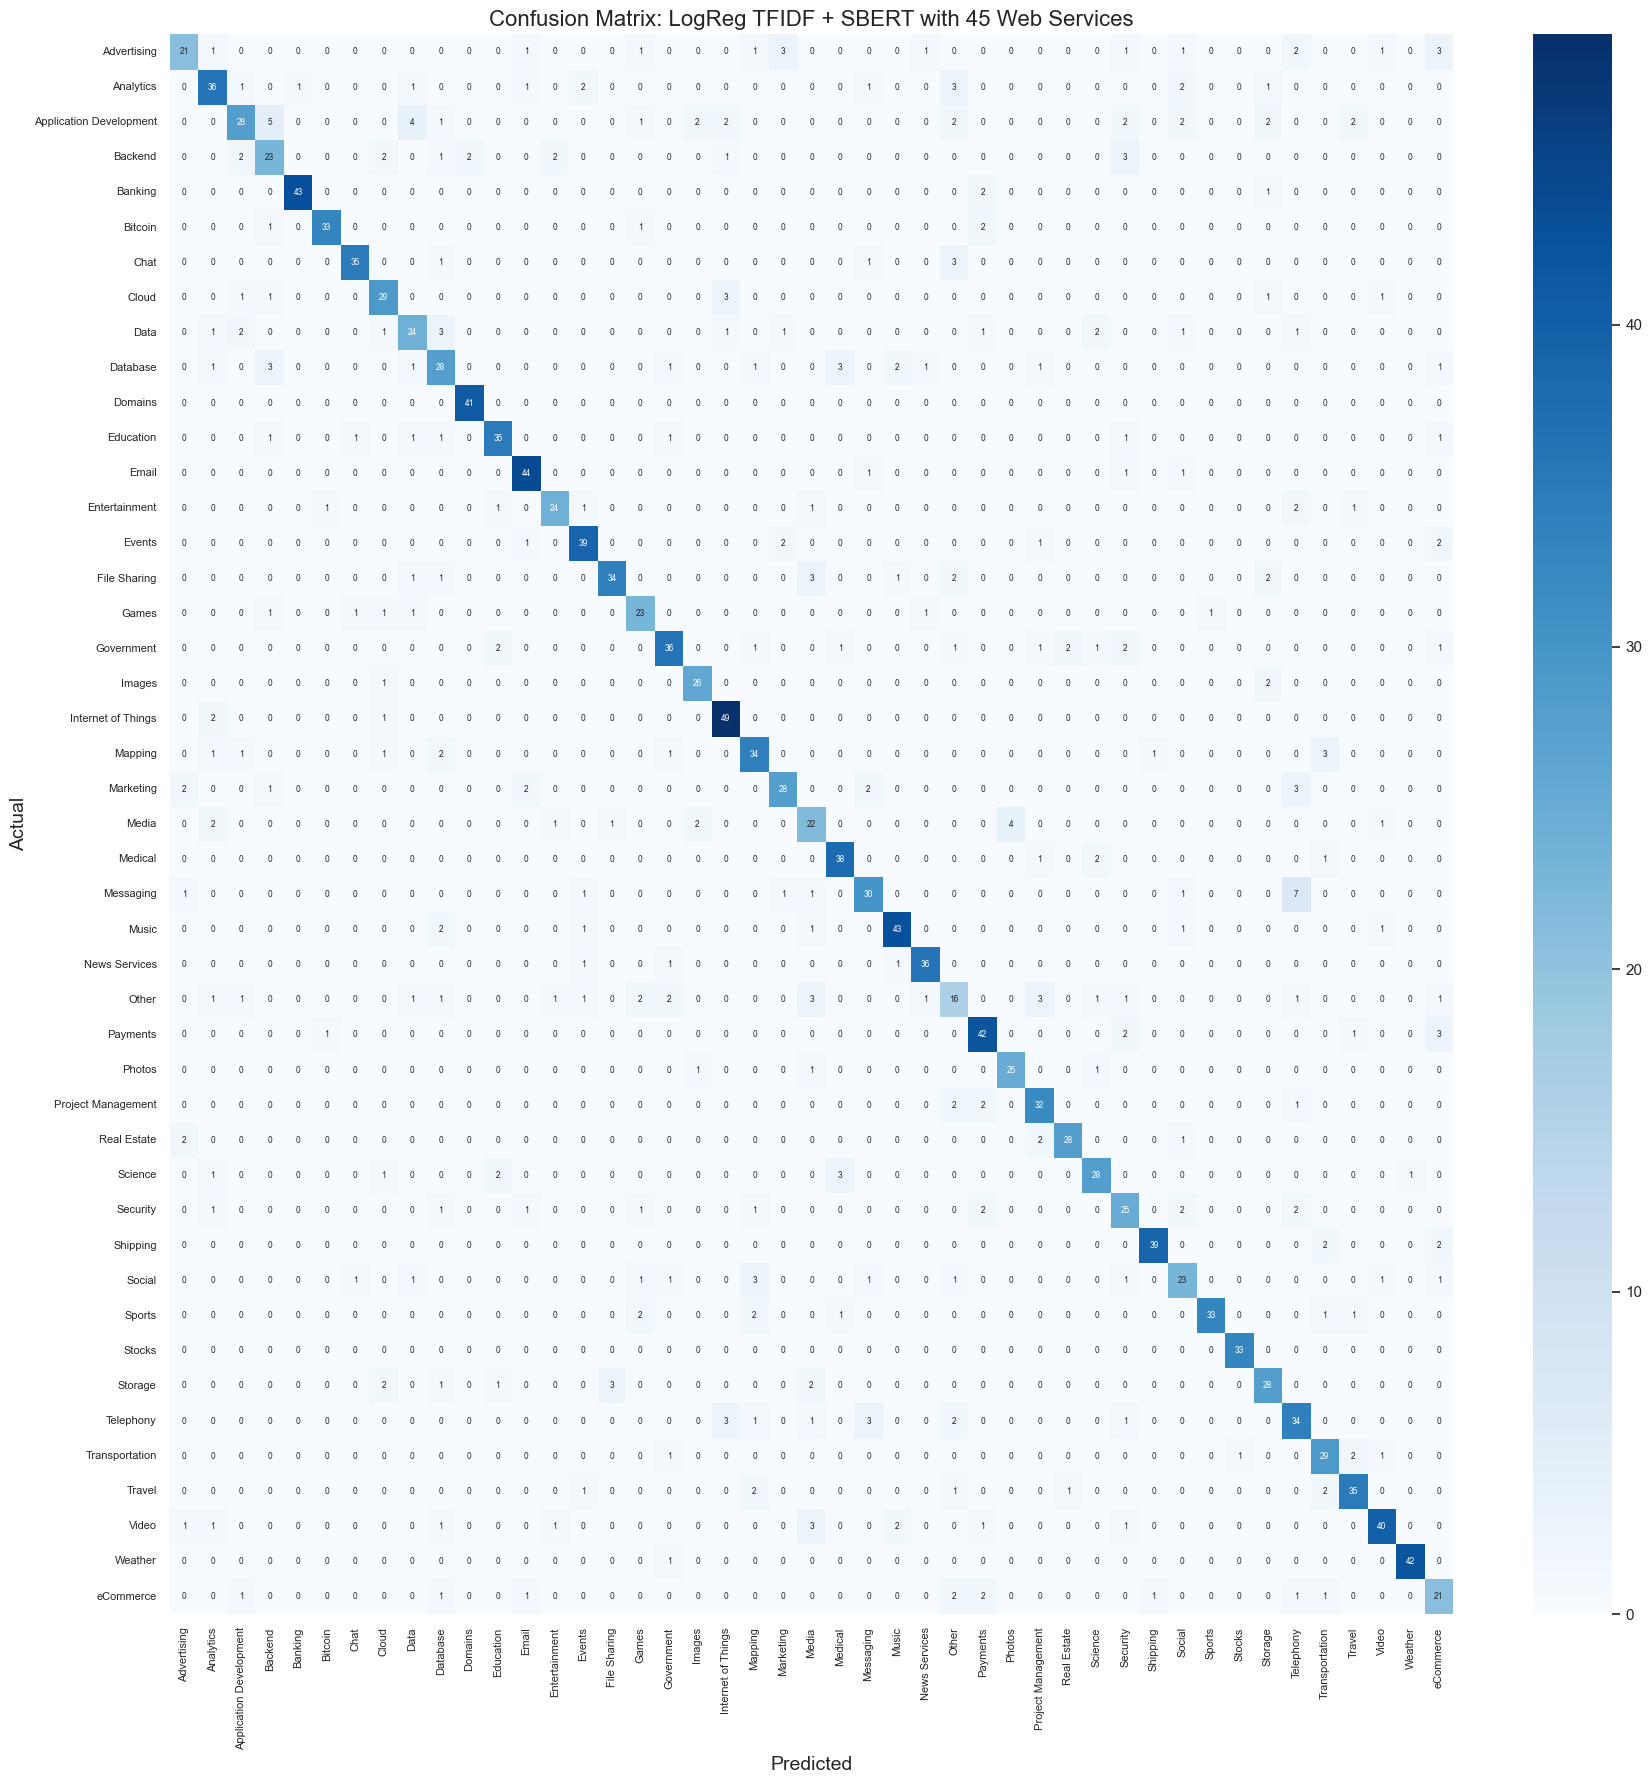

Confusion matrix saved to: charts/ML_confusion_matrix_LogReg_TFIDF_+_SBERT_with_45_Web_Services.png

 RF TFIDF + SBERT with 45 Web Services Classification Report:

                         precision    recall  f1-score   support

            Advertising       0.85      0.59      0.70        37
              Analytics       0.93      0.86      0.89        49
Application Development       0.98      0.79      0.88        53
                Backend       0.97      0.89      0.93        36
                Banking       0.90      0.96      0.93        46
                Bitcoin       0.94      0.92      0.93        37
                   Chat       0.91      0.97      0.94        40
                  Cloud       0.72      0.92      0.80        36
                   Data       0.96      0.66      0.78        38
               Database       0.92      0.84      0.88        43
                Domains       0.98      1.00      0.99        41
              Education       0.71      0.81      0.76 

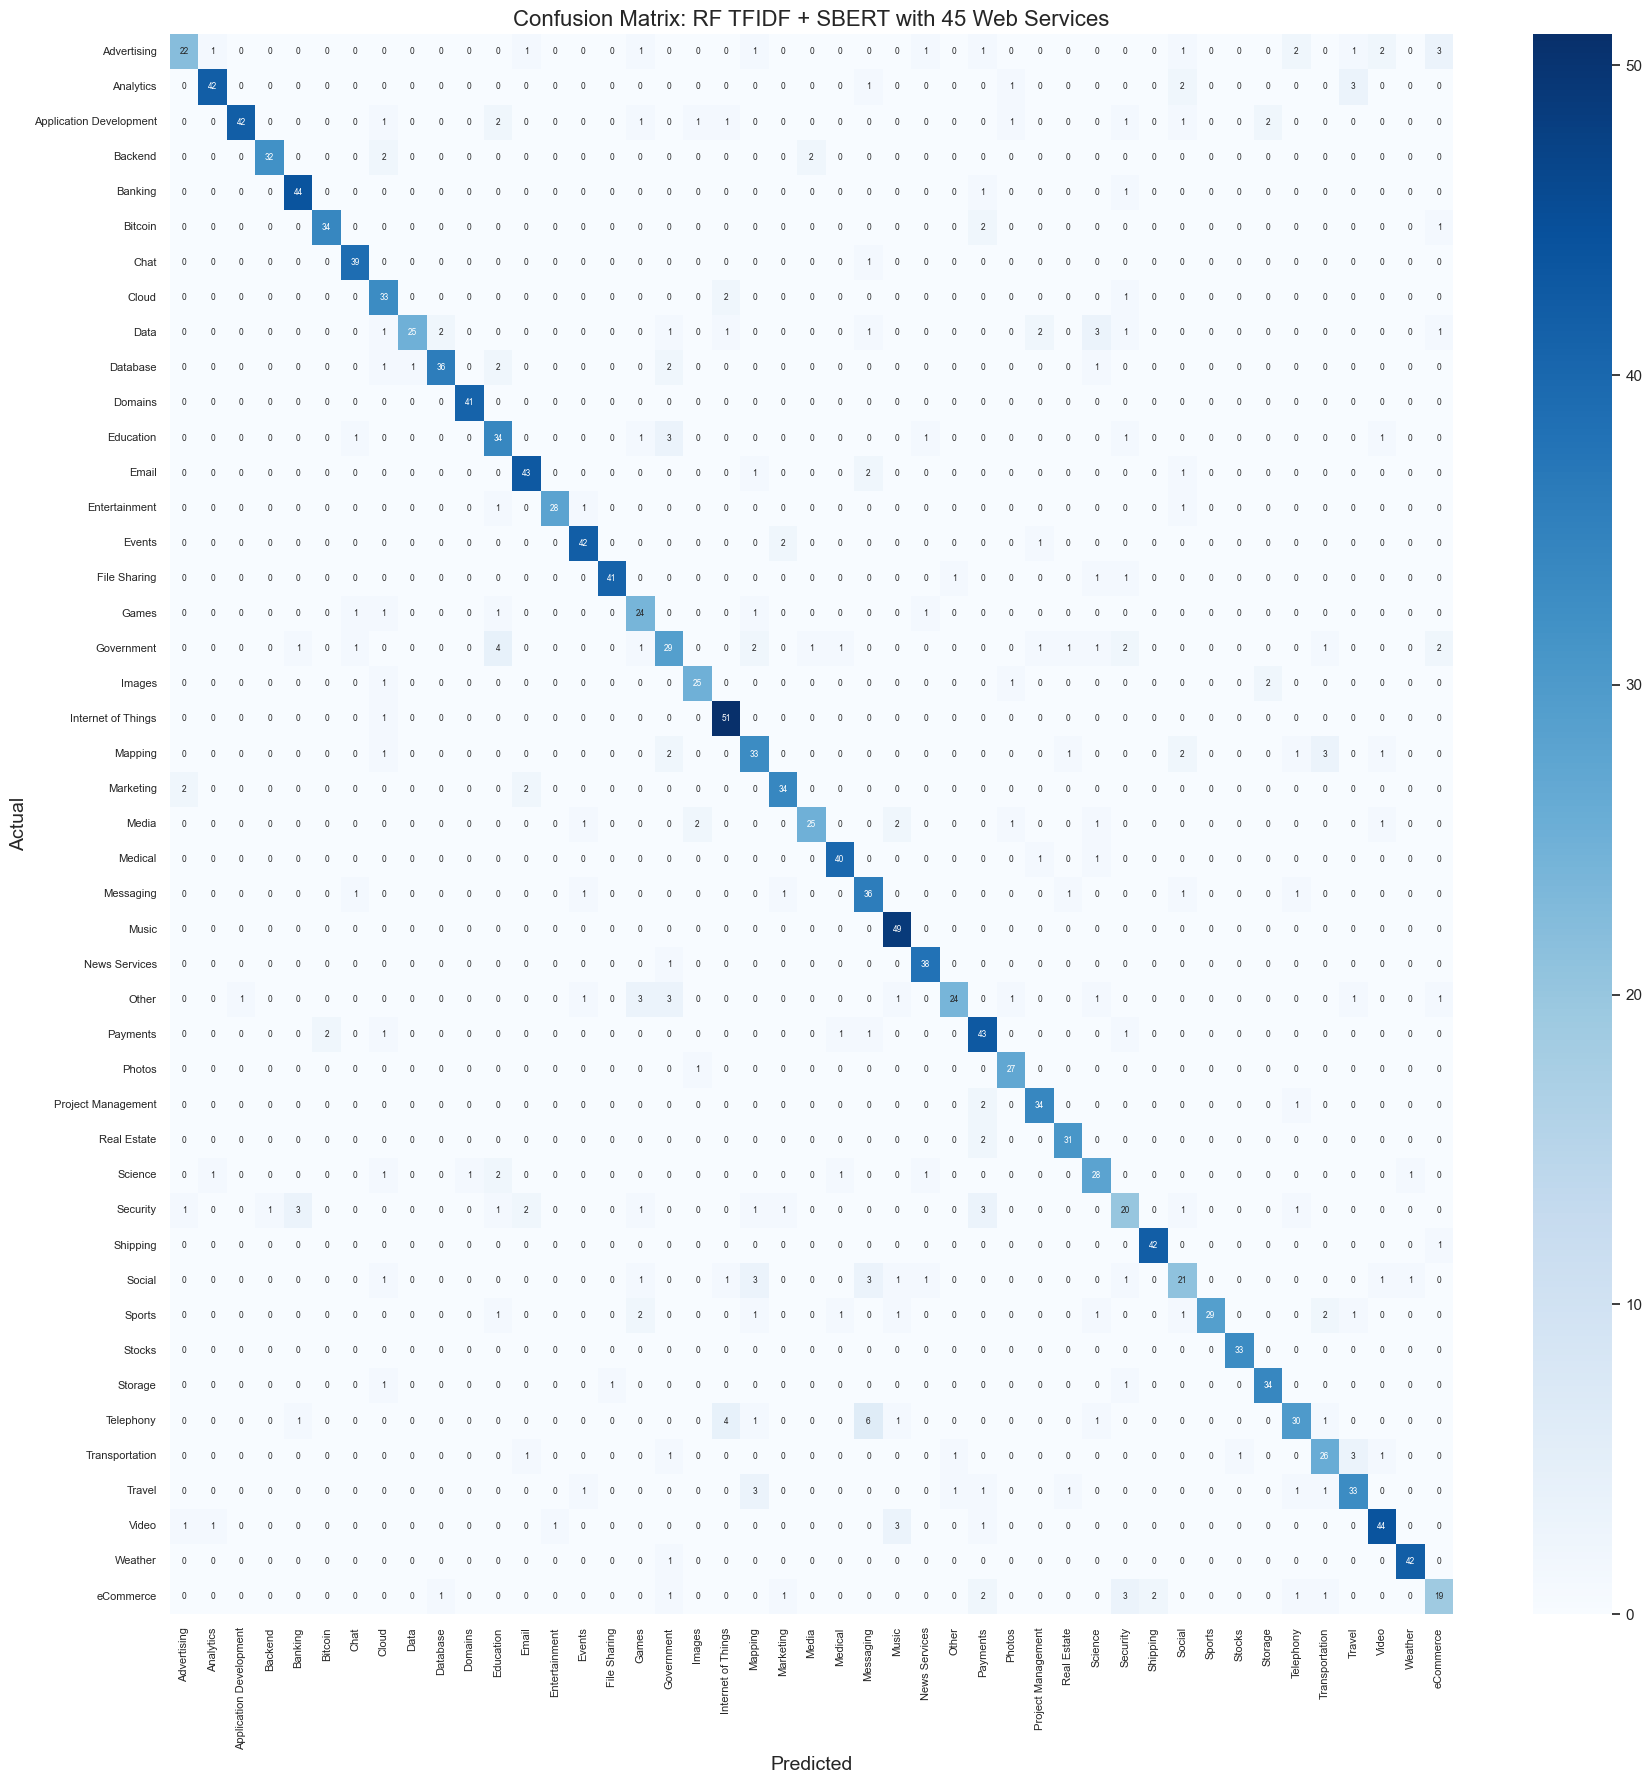

Confusion matrix saved to: charts/ML_confusion_matrix_RF_TFIDF_+_SBERT_with_45_Web_Services.png

 XGB TFIDF + SBERT with 45 Web Services Classification Report:

                         precision    recall  f1-score   support

            Advertising       0.88      0.57      0.69        37
              Analytics       0.88      0.88      0.88        49
Application Development       0.87      0.75      0.81        53
                Backend       0.89      0.92      0.90        36
                Banking       0.98      0.96      0.97        46
                Bitcoin       1.00      0.89      0.94        37
                   Chat       0.91      0.97      0.94        40
                  Cloud       0.79      0.83      0.81        36
                   Data       0.80      0.74      0.77        38
               Database       0.86      0.86      0.86        43
                Domains       0.95      1.00      0.98        41
              Education       0.77      0.81      0.79    

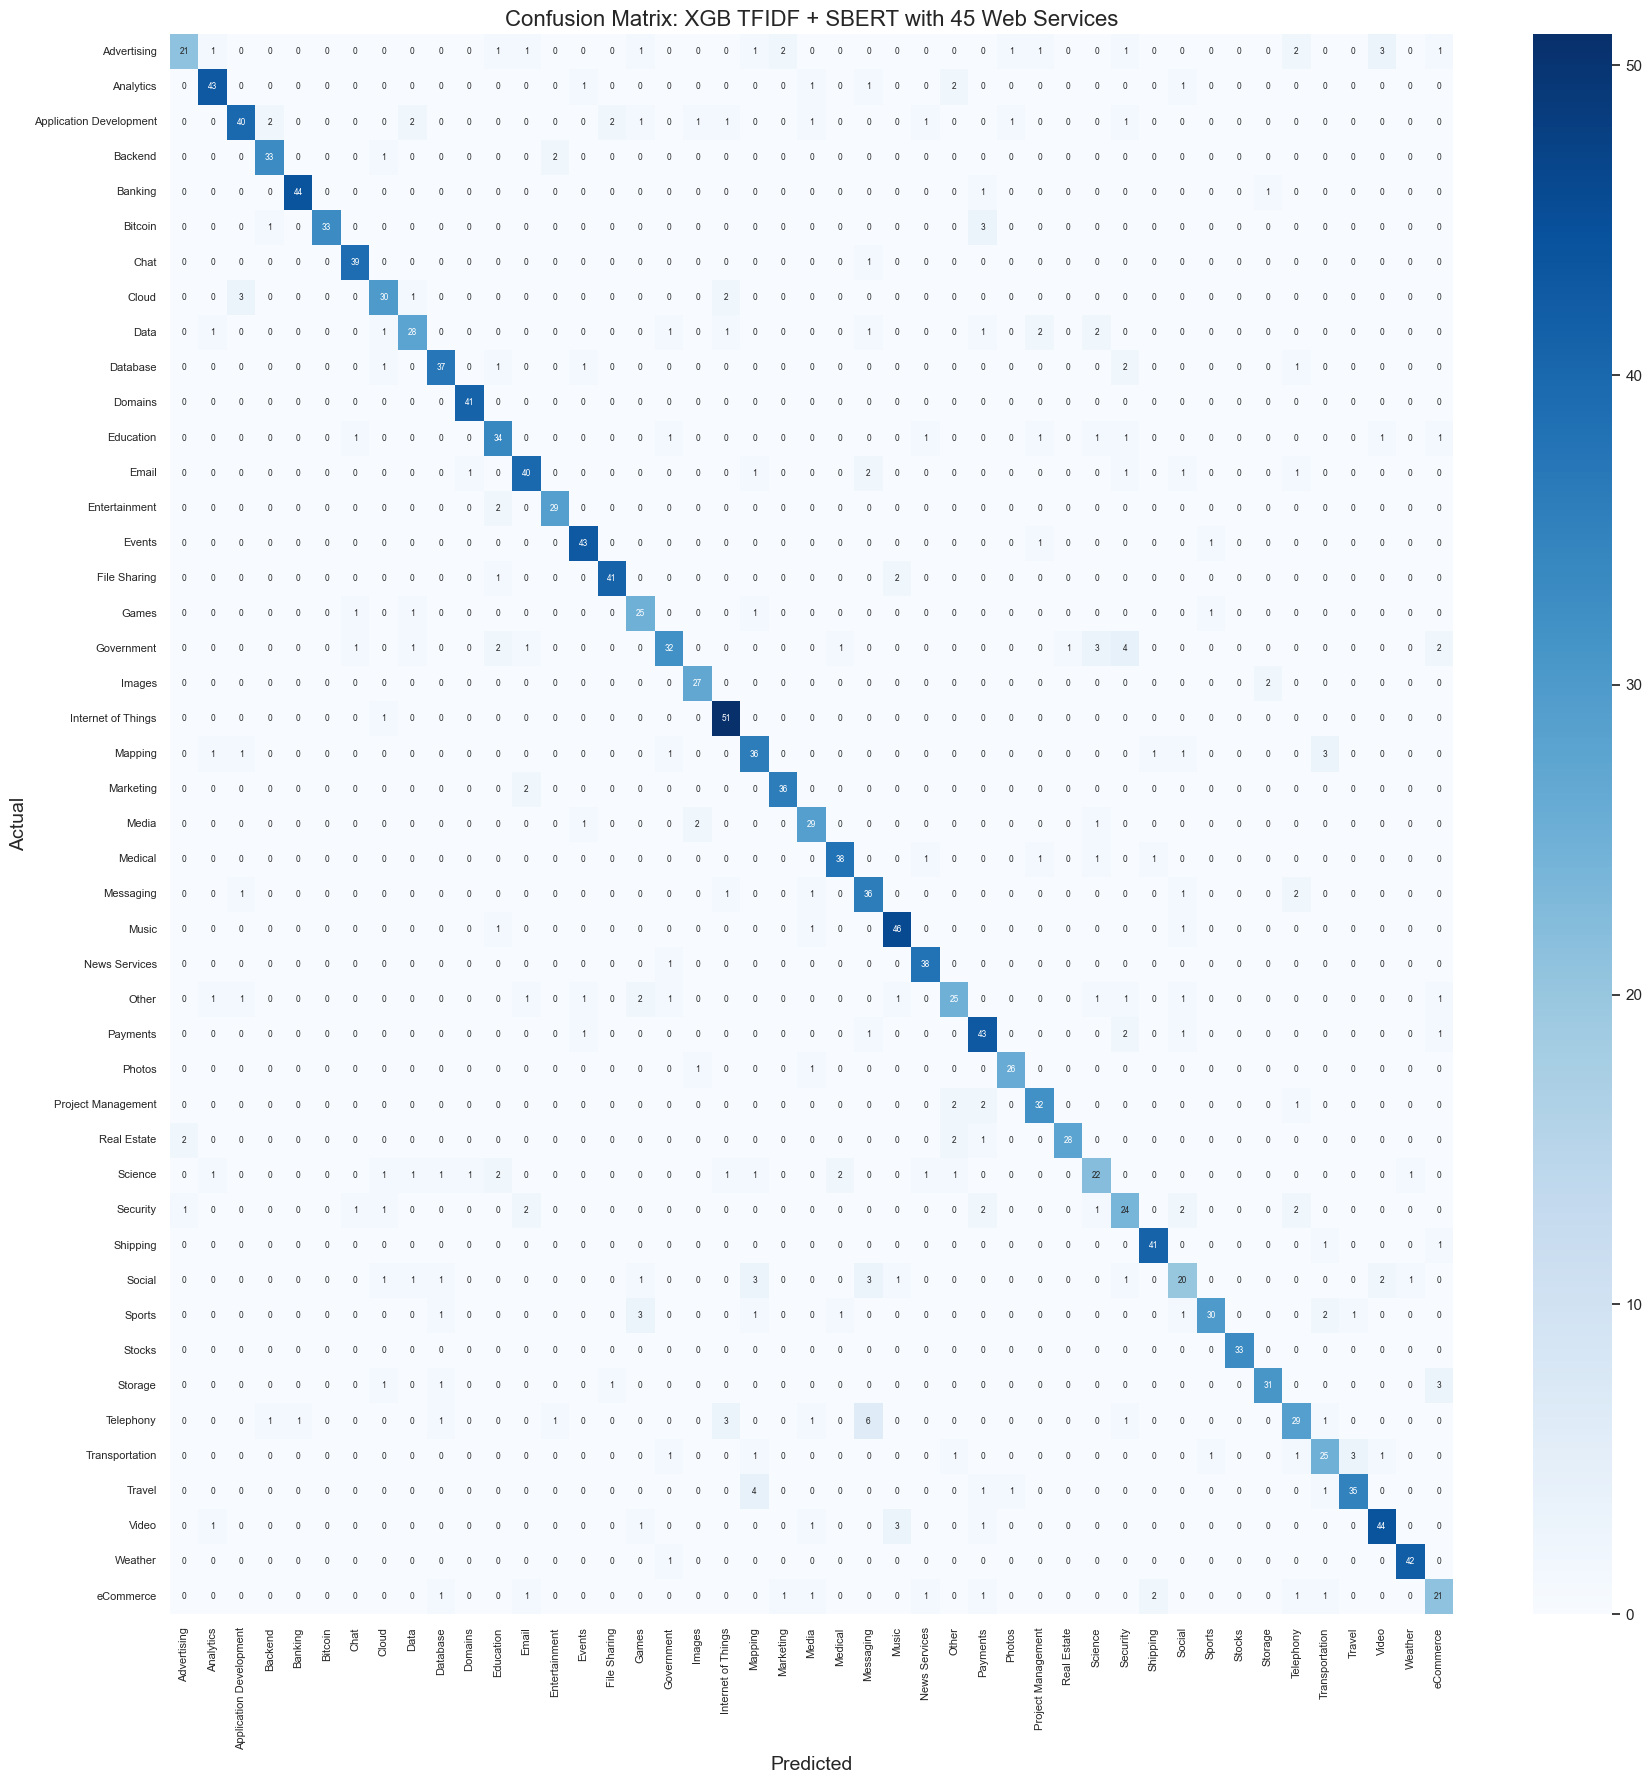

Confusion matrix saved to: charts/ML_confusion_matrix_XGB_TFIDF_+_SBERT_with_45_Web_Services.png


In [9]:
ml_final_results = []
n=45
input_csv = f"../data/Balanced_Top_{n}_Web_Services.csv"
df = pd.read_csv(input_csv)
print(df)
print(df["Grouped Category"].nunique())
print(df["Grouped Category"].value_counts())

basic_inspection_dataset(df)
df['Processed Description'] = df['Service Description'].apply(preprocess_text)

tfidf_df = vectorize_descriptions(df['Processed Description'])
tfidf_output_csv = f"../processed-extacted-features/Processed_Top_{n}_Web_Services_TFIDF.csv"
tfidf_df.to_csv(tfidf_output_csv, encoding='utf-8', index=False, header=True)
print(f"TF-IDF features saved to: {tfidf_output_csv}")

embedding_df = embed_descriptions_with_sbert(df['Processed Description'])
embedding_output_csv = f"../processed-extacted-features/Processed_Top_{n}_Web_Services_SBERT_Embeddings.csv"
embedding_df.to_csv(embedding_output_csv, encoding='utf-8', index=False, header=True)
print(f"SBERT embeddings saved to: {embedding_output_csv}")


for n in [45]:

    tfidf_df = pd.read_csv(f"../processed-extacted-features/Processed_Top_{n}_Web_Services_TFIDF.csv")
    sbert_df = pd.read_csv(f"../processed-extacted-features/Processed_Top_{n}_Web_Services_SBERT_Embeddings.csv")
    original_df = pd.read_csv(f"../data/Balanced_Top_{n}_Web_Services.csv")
    labels = original_df['Grouped Category'].fillna("Unknown")

    combined_df = pd.concat([tfidf_df, sbert_df], axis=1)


    X_train, X_test, y_train, y_test = train_test_split(combined_df, labels, test_size=0.2, random_state=42)


    result=train_and_report_logistic(X_train, X_test, y_train, y_test, name=f"LogReg TFIDF + SBERT with {n} Web Services")
    ml_final_results.append(result)
    
    result=train_and_report_random_forest(X_train, X_test, y_train, y_test, name=f"RF TFIDF + SBERT with {n} Web Services")
    ml_final_results.append(result)
    
    result=train_and_report_xgboost(X_train, X_test, y_train, y_test, name=f"XGB TFIDF + SBERT with {n} Web Services")
    ml_final_results.append(result)


## 4. Performance  and Plots

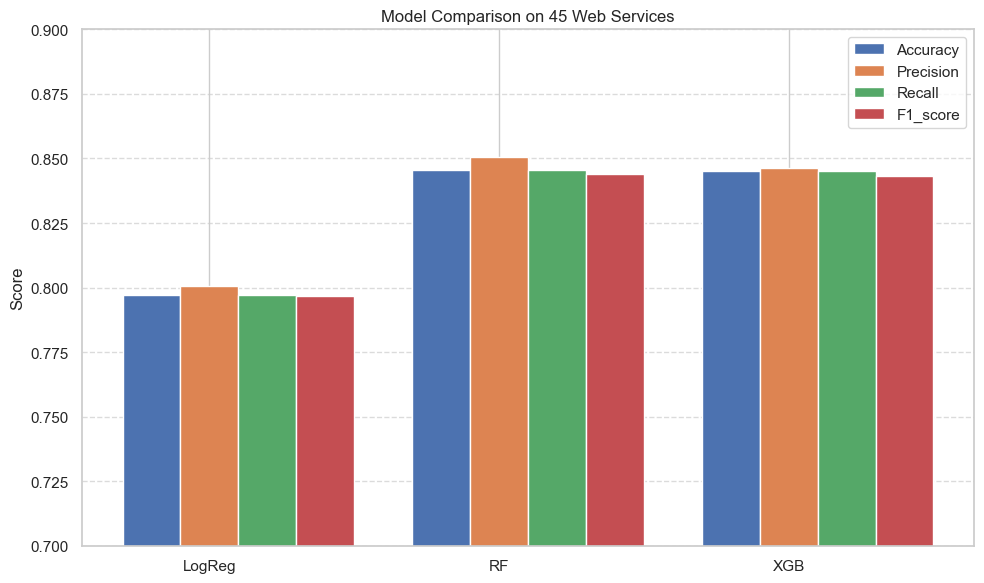

In [11]:
# Save results
with open("results/ml_final_results.pkl", "wb") as f:
    pickle.dump(ml_final_results, f)

import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(ml_final_results)

# Set plot style
plt.figure(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
bar_width = 0.2
x = range(len(df))

# Plot each metric
for i, metric in enumerate(metrics):
    plt.bar([p + bar_width*i for p in x], df[metric], width=bar_width, label=metric.capitalize())

# Labeling
plt.xticks([p + bar_width for p in x], df['model'])
plt.ylabel('Score')
plt.ylim(0.7, 0.9)
plt.title('Model Comparison on 45 Web Services')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()